In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot, rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

In [36]:
# functions
# initial condition function
def rho_red_light(nx, rho_max, rho_in):
    rho = rho_max*numpy.ones(nx)
    rho[:int((nx-1)*3./4.)] = rho_in
    return rho

# flux function
def computeF(u_max, rho_max, rho):
    return u_max*rho*(1-rho/rho_max)

# animationo function
def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

# Lax-Friedrichs scheme
def laxfriedrichs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Friedrichs scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    # initialize our results array with dimension nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    # copy initial rho array into each row of our new array
    rho_n[:,:] = rho.copy()
    '''
    Now, for each timestep, we're going to calculate rho^n+1, 
    then set the value of rho equal to rho^n+1 so we can calculate 
    the next iteration.  For every timestep, the entire vector
    rho^n is saved in a single row of our results array rho_n.
    '''
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:-1] = 0.5*(rho[2:]+rho[:-2]) - dt/(2*dx)*(F[2:]-F[:-2])
        rho_n[t,0] = rho[0] # bc at x = 0
        rho_n[t,-1] = rho[-1] # bc at x = 4
        rho = rho_n[t].copy()
    return rho_n

# Jacobian function
def Jacobian(u_max, rho_max, rho):
    return u_max*(1-2*rho/rho_max)

# Lax-Wendroff function
def laxwendroff(rho, nt, dt, dx, rho_max, u_max):

    # initialize results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    # copy initial rho array into each row of new array
    rho_n[:,:] = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        J = Jacobian(u_max, rho_max, rho)
        
        rho_n[t,1:-1] = rho[1:-1] - dt/(2*dx)*(F[2:]-F[:-2]) \
                            + dt**2/(4*dx**2) * ( (J[2:]+J[1:-1])*(F[2:]-F[1:-1]) \
                            - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2]) )
            
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
    return rho_n



In [3]:
# Basic initial conditions
# defining grid size, time steps, CFL condition, etc..
nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx, rho_max, rho_in)

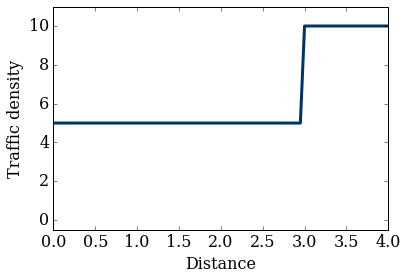

In [4]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

In [5]:
sigma = 1.0
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in) # making sure rho is set to the initial condition
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

In [6]:
rho_n.shape

(30, 81)

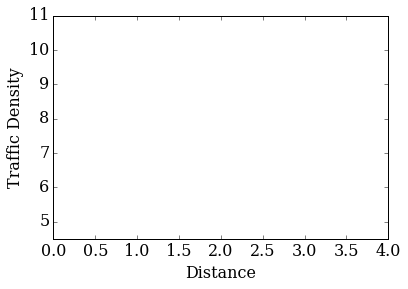

In [7]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel='Distance',ylabel='Traffic Density')
line, = ax.plot([],[],color='#003366',lw=2)

In [8]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

### Thinking:
I see that the shock is not completely straight up and down. As the shock moves to the left there are little horizonal pertubations falling down the gradient. 

I am not sure of the types of errors I am seeing. Oh turns out the steps or perturbations are called odd-even decoupling.

The Lax-Friedrichs scheme is ok so far I guess.

In [9]:
# using smaller time steps:
sigma = 0.5
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in)
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

### Dig deeper:
How does this solution compare witht the previous one where dt/dx = 1?

the steps are more frequent.

### Lax Wendroff scheme:
with \begin{equation} \frac{\Delta t} {\Delta x} = 1 \end{equation}

In [34]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 1
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

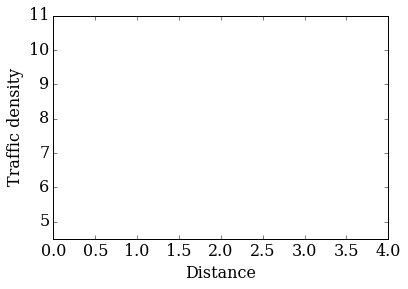

In [25]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11.),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

In [18]:
# this ones is not quite right... Its something with my Lax-Wendroff function
# It was caused by a minus sign between the 2nd Jacobians that should have been a +
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

In [35]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

Now with with \begin{equation} \frac{\Delta t} {\Delta x} = 0.5 \end{equation}

In [37]:
rho = rho_red_light(nx, rho_max, rho_in) 
sigma = 0.5
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

Why do we observe oscillations with second order methods (a question of fundemental importance!)?

At this point I don't know.

### MacCormack Scheme:
